## **STUMPY**


In [4]:
# !pip install stumpy
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import stumpy
import numpy as np
from numba import cuda
import time

### **MATRIX PROFILE**
<br>
https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html <br>

The stumpy library computes the **matrix profile**, namely a vector that stores z-normalized euclidean distance between any subseqeunce whitin a time series and its NN. In other words, given two time series, for each pair of subsequences, the euclidean distance is computed and stored in the matrix profile. 

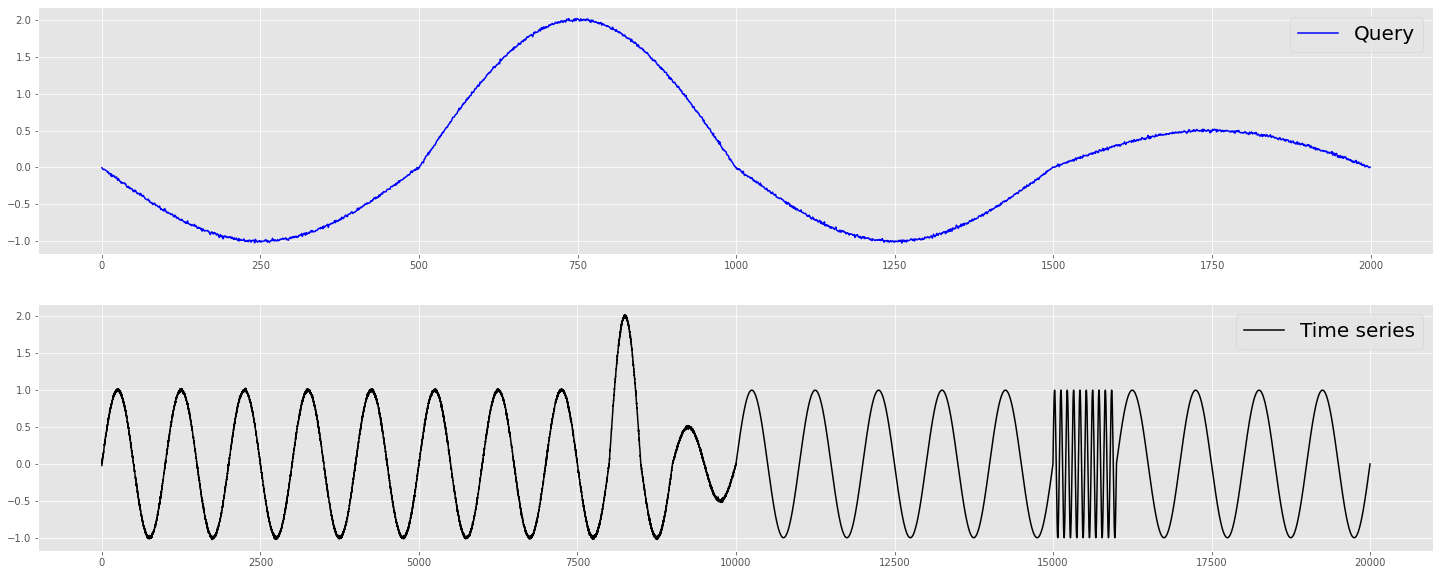

In [82]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (25, 10))


# time series. 
N = 20000
x = np.linspace(-20*np.pi, 20*np.pi, N) 
x[15000:16000] = x[15000:16000] * 10
ts = np.sin(x)
ts[8000:8500] = ts[8000:8500]*2 
ts[9000:10000] = ts[9000:10000]*0.5
ts[0:(len(x) // 2)] = ts[0:(len(x) // 2)] + np.random.normal(0, 0.01, len(x) // 2)

Q = ts[7500:9500]
T = ts.copy()

ax1.plot(Q, color = 'Blue', label = 'Query')
ax1.legend(fontsize = 20)
ax2.plot(T, color = 'black', label = 'Time series');
ax2.legend(fontsize = 20);

### **stumpy.stump(T_A, m, T_B=None, ignore_trivial=True, normalize=True)**
<br>
https://stumpy.readthedocs.io/en/latest/api.html#stumpy.stump <br>
Compute the z-normalized matrix profile. The output is:
- The first column is the matrix profile, i.e. the distane between the i-th subseque ce and the NN. 
- The second consists of the matrix profile indeces. 
- The third column consists of the left matrix profile indices.
- The fourth column consists of the right matrix profile indices.
<br>
Its complexity is equal to O(N).

In [86]:
%%timeit

stumpy.stump(T_A = ts,
             T_B = Q,
             m = w,
             ignore_trivial = False # aB-join, not self-join
            )

43.1 ms ± 1.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [68]:
w = len(Q)

matrix_profile = stumpy.stump(T_A = ts, # The time series or sequence for which to compute the matrix profile.
                              T_B = Q, # The time series or sequence that will be used to annotate T_A.
                              m = w,
                              ignore_trivial = False # aB-join, not self-join
                             )
matrix_profile = pd.DataFrame(matrix_profile)
matrix_profile.columns = ['Distance', 'Index', 'Left', 'Right']
matrix_profile.head()

,Distance,Index,Left,Right
0,87.2636,0,-1,-1
1,87.2633,0,-1,-1
2,87.2626,0,-1,-1
3,87.2606,0,-1,-1
4,87.2578,0,-1,-1


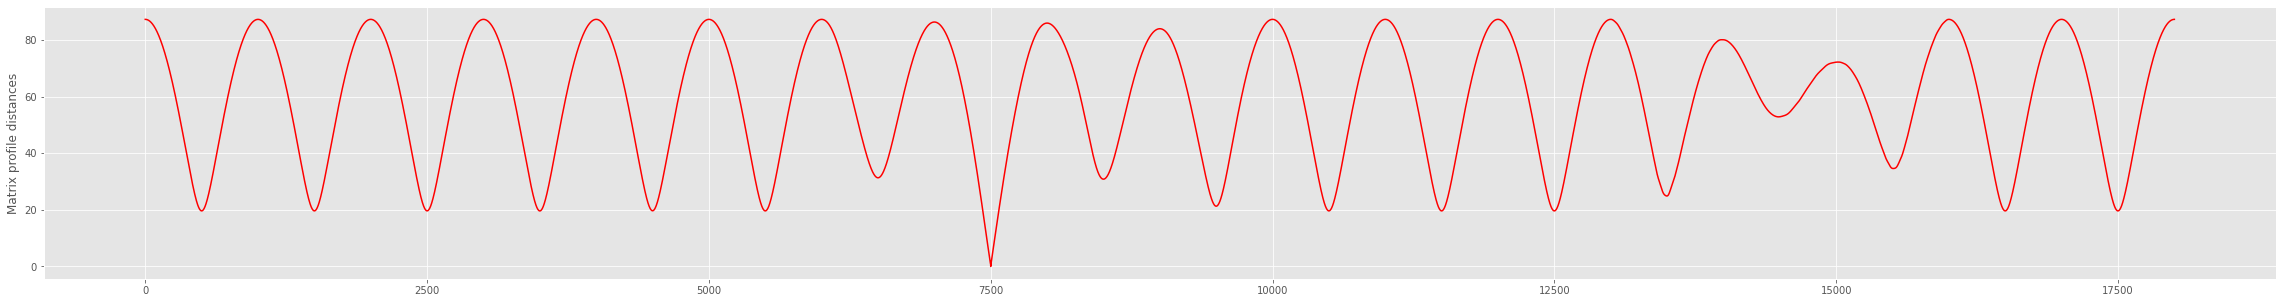

In [69]:
plt.figure(figsize = (40, 5))
plt.plot(matrix_profile['Distance'], color = 'Red')
plt.ylabel('Matrix profile distances');

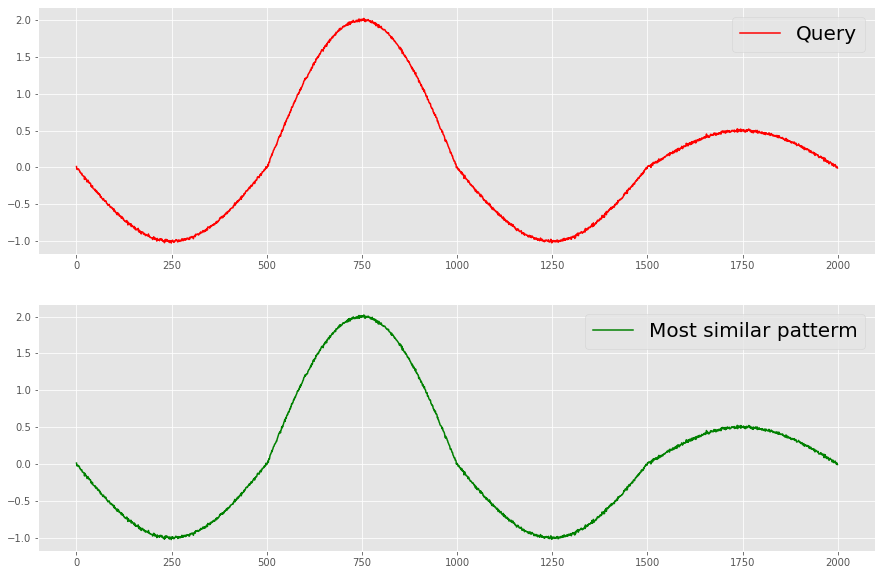

In [70]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 10))


ax1.plot(Q, color = 'red', label = 'Query')
ax1.legend(fontsize = 20)
min_index = np.argmin(matrix_profile.Distance)
ax2.plot(ts[min_index:(min_index+len(Q))], color = 'green', label = 'Most similar patterm')
ax2.legend(fontsize = 20);

### **stumpy.scrump(ts m, percentage=0.01, pre_scrump=True, s=None)**
https://stumpy.readthedocs.io/en/latest/Tutorial_Fast_Approximate_Matrix_Profiles.html <br>
It's an approximation to save time and not to compute the full matrix profile.
The main idea is to computes this distance matrix in a diagonal-wise fashion but only using a subset of all diagonals.
How many pairwise distances along the diagonals you want to compute is controlled by the percentage argument.

In [88]:
%%timeit

stumpy.scrump(T_A = ts, # The time series or sequence for which to compute the matrix profile.
                               T_B = Q, # The time series or sequence that will be used to annotate T_A.
                               m = w,
                               ignore_trivial = False, 
                               percentage = 0.01, # quante diagonali voglio considerare nella computazione. 
                               pre_scrump=False # pre-processing: dovrebbe aumentare l'accuratezza.
                              )

28.8 ms ± 872 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [77]:

matrix_prof_approx = stumpy.scrump(T_A = ts, # The time series or sequence for which to compute the matrix profile.
                                   T_B = Q, # The time series or sequence that will be used to annotate T_A.
                                   m = w,
                                   ignore_trivial = False, 
                                   percentage=1, # quante diagonali voglio considerare nella computazione. 
                                   pre_scrump=False # pre-processing: dovrebbe aumentare l'accuratezza.
                                  )

# matrix_prof_approx = pd.DataFrame(matrix_prof_approx)
# matrix_prof_approx.columns = ['Distance']
matrix_prof_approx.update()
matrix_prof_approx = matrix_prof_approx.P_

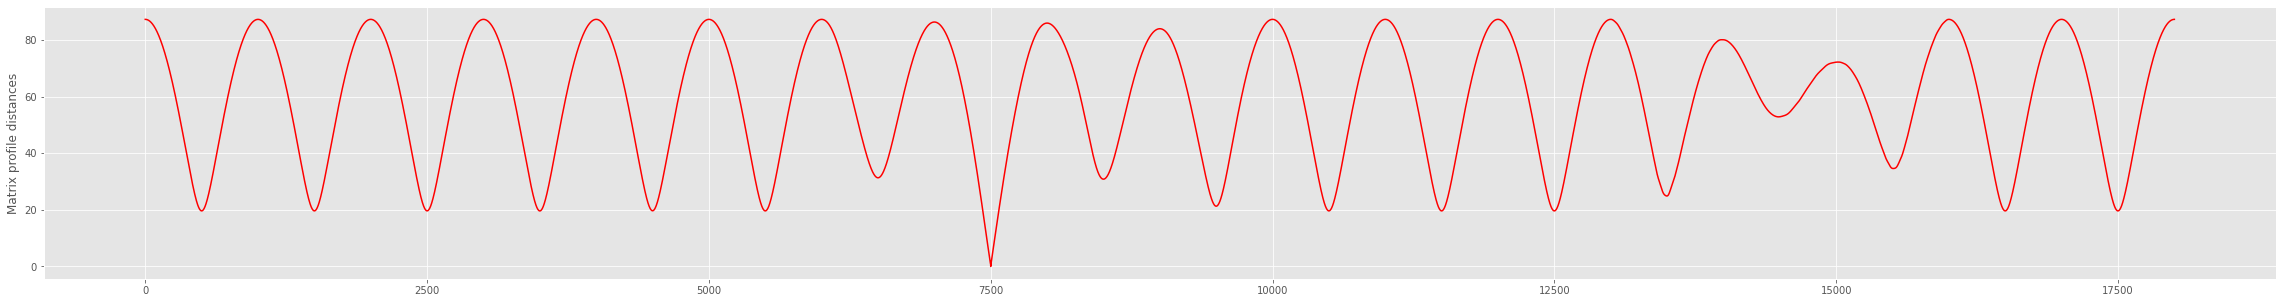

In [78]:
# anche con percentuali basse riesce comunque a trovare un profilo molto simile a quello precedente.
plt.figure(figsize = (40, 5))
plt.plot(matrix_prof_approx, color = 'Red')
plt.ylabel('Matrix profile distances');
# sono praticamente identici.

In [ ]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 10))


ax1.plot(Q, color = 'red', label = 'Query')
ax1.legend(fontsize = 20)
ax2.plot(T[min_index:(min_index+len(Q))], color = 'green', label = 'Most similar patterm')
ax2.legend(fontsize = 20);

### **stumpy.mass(Q, T, M_T=None, Σ_T=None, normalize=True)**
https://stumpy.readthedocs.io/en/latest/api.html#stumpy.mass <br>
It computes the pairwise distances through the mass algorithm. It's the fastest.


In [89]:
%%timeit 

stumpy.mass(Q, T)

13.3 ms ± 634 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


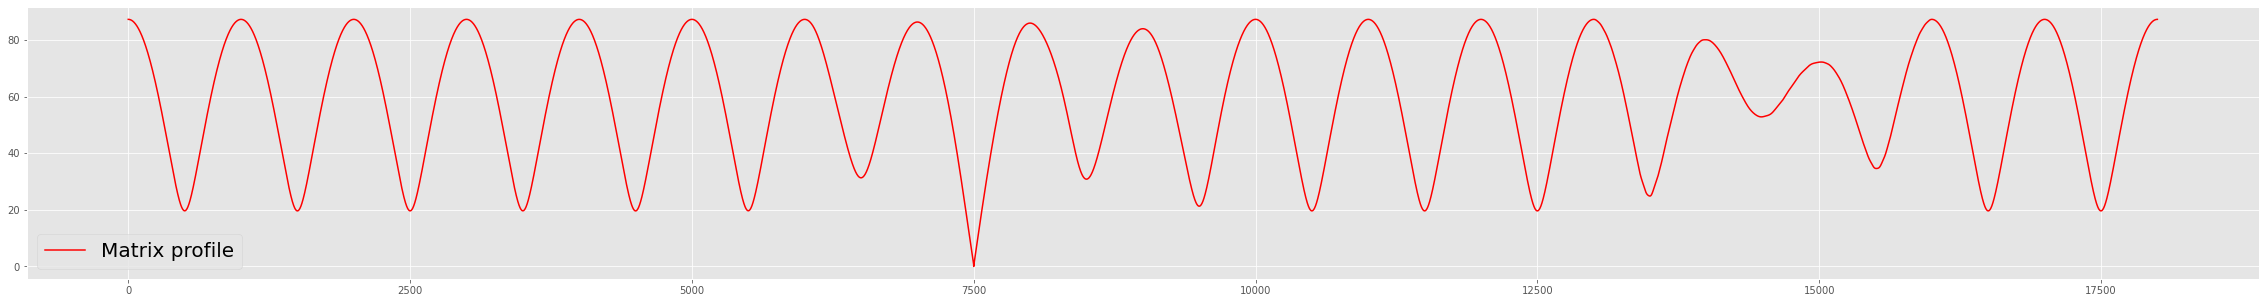

In [85]:
matrix_profile = stumpy.mass(Q, T)
min_index = np.argmin(matrix_profile)
# matrix_profile[min_index]

plt.figure(figsize = (40, 5))
plt.plot(matrix_profile, label = 'Matrix profile', color = 'red')
plt.legend(fontsize = 20)

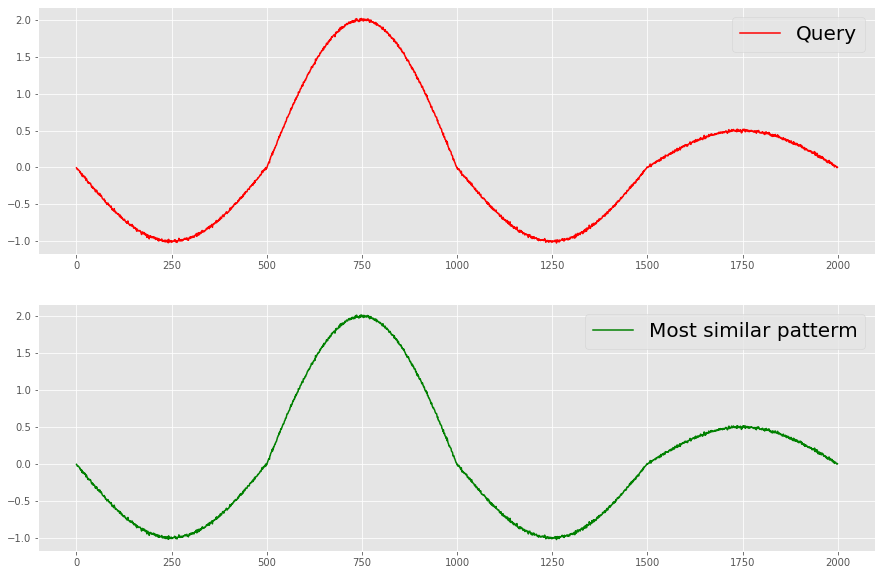

In [84]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 10))


ax1.plot(Q, color = 'red', label = 'Query')
ax1.legend(fontsize = 20)
ax2.plot(T[min_index:(min_index+len(Q))], color = 'green', label = 'Most similar patterm')
ax2.legend(fontsize = 20);